# 必要な計算環境

* Linux OS
* Pascal, Volta, Turing, 或いは NVIDIA Ampere 世代 GPU
* Nvidia Driver
* Docker

# 事前準備

* [NGC](https://catalog.ngc.nvidia.com/?filters=&orderBy=weightPopularDESC&query=&page=&pageSize=)の登録と[APIキー](https://org.ngc.nvidia.com/setup/api-key)の取得は済みましたか？
* [Weights and Biases]((https://docs.wandb.ai/quickstart)) の登録と[APIキー](https://docs.wandb.ai/guides/track/public-api-guide#authentication)の取得は済みましたか？

### NGC のセットアップ
NGCからモデルをダウンロードしたい場合は、APIキーが必要になりますので、取得してください。
### Weights and Biases のセットアップ
モデルのトレーニング進行状況やチャートは、 [Weights and Biases](https://docs.wandb.ai/quickstart) を通じて可視化できます。ログを有効にするために、 [API キー](https://docs.wandb.ai/guides/track/public-api-guide#authentication)を設定してください。

In [ ]:
import os
os.environ["WANDB_ENTITY"]="wandb-healthcare"
os.environ["WANDB_PROJECT"]="BioNeMo_Molecure_LLM"

# GPUの確認

In [ ]:
!nvidia-smi

# データの前処理

BioNeMo Frameworkのモデルトレーニング機能を簡単に紹介するために、サンプルデータセットとして提供されている元のZINC15データセットの非常に小さなサブセットを使用します。このサブセットは、 ${BIONEMO_HOME}/examples/tests/test_data/molecule に位置しています。

このテスト実行のために、フォルダには/train、/val、/testの各フォルダが含まれており、それぞれのフォルダにはCSVファイル形式のタンパク質配列が含まれています。これらのディレクトリ内で、それぞれ何ファイルが作成されたかを確認し、以下の例のコマンドにおける TRAIN_FILE_RANGE、VAL_FILE_RANGE、TEST_FILE_RANGE のパラメータをそれに応じて修正してください。現在のコマンド設定では、train および test ディレクトリには 175 ファイル、val ディレクトリには 4 ファイルが扱われるように設定されています。

In [ ]:
cd /workspace/bionemo

In [ ]:
!python examples/molecule/molmim/pretrain.py\
 --config-path conf\
 --config-name molmim_70m_24_3\
 ++do_training=False\
 ++trainer.devices=1 \
 ++trainer.num_nodes=1 \
 ++model.data.dataset_path=/workspace/bionemo/examples/molecule/molmim/data \
 ++model.data.links_file=/workspace/bionemo/examples/molecule/megamolbart/dataset/ZINC-downloader-sample.txt \
 ++exp_manager.create_wandb_logger=False

In [ ]:
"""
import wandb
with wandb.init(name="data_upload") as run:
    artifact = wandb.Artifact(
        name="small_ZINC",
        type="dataset",
        description="subset of ZINC",
        metadata={"path":"/workspace/bionemo/examples/tests/test_data/molecule"},
    )
    artifact.add_dir("/workspace/bionemo/examples/molecule/molmim/data")
    run.log_artifact(artifact)
"""

# モデルの事前学習

このテスト実行では、${BIONEMO_HOME}/examples/molecule/molmim/conf フォルダにある pretrain_small_canonicalized_logv.yaml 設定ファイルに提供されている事前設定されたパラメータを使用します。これは、MolMIM-70M-24.3 チェックポイントをトレーニングするために使用された設定です。

In [ ]:
cd /workspace/bionemo 

データのサイズによって、TRAIN_FILE_RANGE、TEST_FILE_RANGE、VAL_FILE_RANGEを設定してください。

In [ ]:
TRAIN_FILE_RANGE="x_OP_000..175_CL_"
TEST_FILE_RANGE="x_OP_000..004_CL_"
VAL_FILE_RANGE="x_OP_000..175_CL_"

In [ ]:
import os
os.environ["HYDRA_FULL_ERROR"]="1"

In [ ]:
!python examples/molecule/molmim/pretrain.py\
 --config-path conf\
 --config-name molmim_70m_24_3\
 ++trainer.devices=1 \
 ++trainer.num_nodes=1 \
 ++trainer.max_steps=100 \
 ++trainer.accumulate_grad_batches=1 \
 ++trainer.val_check_interval=5 \
 ++trainer.limit_val_batches=1.0 \
 ++trainer.precision=32 \
 ++model.micro_batch_size=128 \
# ++model.global_batch_size=256 \
 ++model.dwnstr_task_validation.enabled=False \
 ++model.data.dataset_path=/examples/molecule/molmim/data \
 ++model.data.dataset.train=$TRAIN_FILE_RANGE \
 ++model.data.dataset.val=$VAL_FILE_RANGE \
 ++model.data.dataset.test=$TEST_FILE_RANGE \
 ++model.data.index_mapping_dir=/results/data_index/ \
 ++model.seq_length=128 \
 ++exp_manager.exp_dir=/results/logs/ \
 ++exp_manager.create_wandb_logger=True

# CMA-ESを使用したMolMIMによる特性ガイド分子最適化

このセッションは、BioNeMo Framework からMolMIMのチェックポイントをロードし、カスタムのユーザー定義スコアリング機能を使用して興味のあるいくつかの分子を最適化する方法を示します。CMA-ESを使用してMolMIMモデルの潜在空間をトラバースし、スコアリング機能によって測定されたパフォーマンスを向上させると期待される新しい関連分子を選択します。これらの分子をサンプリングするためには、以下のステップを完了する必要があります：

1. 望むMolMIMチェックポイントをロードする。

2. 開始分子をMolMIMの潜在空間にエンコードする。

3. CMA-ESを実行し、以下を繰り返し実行する：

    * 潜在表現をSMILES文字列にデコードする。
    * これらのSMILES文字列にユーザー定義のスコアリング機能を適用し、SMILES/スコアのペアを生成する。
    * 新しい潜在空間表現のセットをCMA-ESアルゴリズムに要求する。

では、事前学習済みモデルをダウンロードします。モデルをダウンロードするため、ngc をインストールして、ngc config を設定する必要があります。

In [1]:
#一度Kernelをrestartしてください
import os
os.environ["WANDB_ENTITY"]="wandb-healthcare"
os.environ["WANDB_PROJECT"]="BioNeMo_Molecure_optimization"

In [2]:
!pip install optuna statsmodels -qqq

In [3]:
!wget -q -O /tmp/ngccli_linux.zip --content-disposition https://api.ngc.nvidia.com/v2/resources/nvidia/ngc-apps/ngc_cli/versions/3.38.0/files/ngccli_linux.zip && unzip -o /tmp/ngccli_linux.zip -d /tmp && chmod u+x /tmp/ngc-cli/ngc && rm /tmp/ngccli_linux.zip

Archive:  /tmp/ngccli_linux.zip
  inflating: /tmp/ngc-cli/boto3/examples/s3.rst  
  inflating: /tmp/ngc-cli/boto3/examples/cloudfront.rst  
  inflating: /tmp/ngc-cli/boto3/data/dynamodb/2012-08-10/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/sqs/2012-11-05/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/opsworks/2013-02-18/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/iam/2010-05-08/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2014-10-01/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2015-10-01/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2015-03-01/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2016-09-15/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2016-04-01/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2015-04-15/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/ec2/2016-11-15/resources-1.json  
  inflating: /tmp/ngc-cli/boto3/data/s3/2006-03-01/resources-1.json  

そして、ターミナルを開いて、下記のコマンドを入力して、 ngc config set をしてください。

/tmp/ngc-cli/ngc config set

<順番にAPI キー、CLI output format, org, team, aceを入力してください。API キーはNGCのAPIキーを入力してください。Org は ’no-org’ 以外のものを選択して、その他は「Enter」でデフォルト値を入力すれば大丈夫です>

最後に、下記のコマンドを入力すれば、モデルをダウンロードできます。

In [4]:
cd /workspace/bionemo 

/workspace/bionemo


In [5]:
!python download_models.py --download_dir /workspace/bionemo/models molmim_70m_24_3

Running command: ngc --version

NGC CLI 3.42.0

Done.
Running command: mkdir -p /workspace/bionemo/models && ngc registry model download-version nvidia/clara/molmim:1.3 --dest /workspace/bionemo/models && mv /workspace/bionemo/models/molmim_v1.3/* /workspace/bionemo/models/ && rm -d /workspace/bionemo/models/molmim_v1.3


Done.
Running command: mkdir -p /workspace/bionemo/models/molecule/molmim && ln -sf ../../molmim_70m_24_3.nemo /workspace/bionemo/models/molecule/molmim/molmim_70m_24_3.nemo


Done.


## チェックポイントをmolmim推論ラッパーにロード

In [6]:
from bionemo.utils.hydra import load_model_config
import os
from bionemo.model.molecule.molmim.infer import MolMIMInference
bionemo_home=f"/workspace/bionemo"
os.environ['BIONEMO_HOME'] = bionemo_home
checkpoint_path = f"{bionemo_home}/models/molecule/molmim/molmim_70m_24_3.nemo"
cfg = load_model_config(config_name="molmim_infer.yaml", config_path=f"{bionemo_home}/examples/tests/conf/") # reasonable starting config for molmim inference
# This is the field of the config that we need to set to our desired checkpoint path.
cfg.model.downstream_task.restore_from_path = checkpoint_path
model = MolMIMInference(cfg, interactive=True)

[NeMo I 2024-05-29 03:17:07 megatron_hiddens:110] Registered hidden transform sampled_var_cond_gaussian at bionemo.model.core.hiddens_support.SampledVarGaussianHiddenTransform
[NeMo I 2024-05-29 03:17:07 megatron_hiddens:110] Registered hidden transform interp_var_cond_gaussian at bionemo.model.core.hiddens_support.InterpVarGaussianHiddenTransform
[NeMo I 2024-05-29 03:17:07 utils:334] Restoring model from /workspace/bionemo/models/molecule/molmim/molmim_70m_24_3.nemo
[NeMo I 2024-05-29 03:17:07 utils:338] Loading model class: bionemo.model.molecule.molmim.molmim_model.MolMIMModel
Interactive mode selected, using strategy='auto'


INFO: GPU available: True (cuda), used: True
I0529 03:17:07.679289 131172322451456 rank_zero.py:53] GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
I0529 03:17:07.680823 131172322451456 rank_zero.py:53] TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
I0529 03:17:07.681936 131172322451456 rank_zero.py:53] IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
I0529 03:17:07.683910 131172322451456 rank_zero.py:53] HPU available: False, using: 0 HPUs


[NeMo I 2024-05-29 03:17:07 exp_manager:394] Experiments will be logged at /workspace/bionemo/test_results/nemo_experiments/molmim_infer/MolMIM_Inference/2024-05-29_03-17-07
[NeMo I 2024-05-29 03:17:07 utils:307] 
    
    ************** Trainer configuration ***********
[NeMo I 2024-05-29 03:17:07 utils:308] 
    name: MolMIM_Inference
    desc: Minimum configuration for initializing a MolMIM model for inference.
    trainer:
      precision: 16-mixed
      devices: 1
      num_nodes: 1
      accelerator: gpu
      logger: false
      accumulate_grad_batches: 1
    exp_manager:
      explicit_log_dir: null
      exp_dir: ${oc.env:BIONEMO_HOME}/test_results/nemo_experiments/molmim_infer
      name: ${name}
      create_checkpoint_callback: false
      create_wandb_logger: false
      create_tensorboard_logger: false
      wandb_logger_kwargs:
        offline: true
    model:
      encoder:
        num_layers: 6
        hidden_size: 512
        ffn_hidden_size: 2048
        num_attentio

[NeMo W 2024-05-29 03:17:08 megatron_base_model:821] The model: MolMIMModel() does not have field.name: context_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-05-29 03:17:08 megatron_base_model:821] The model: MolMIMModel() does not have field.name: virtual_pipeline_model_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-05-29 03:17:08 megatron_base_model:821] The model: MolMIMModel() does not have field.name: sequence_parallel in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-05-29 03:17:08 megatron_base_model:821] The model: MolMIMModel() does not have field.name: expert_model_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-05-29 03:17:08 megatron_base_model:821] The model: MolMIMModel() does not have field.name: use_cpu_initialization in its cfg. Add this 

[NeMo I 2024-05-29 03:17:08 megatron_init:234] Rank 0 has data parallel group: [0]
[NeMo I 2024-05-29 03:17:08 megatron_init:237] All data parallel group ranks: [[0]]
[NeMo I 2024-05-29 03:17:08 megatron_init:238] Ranks 0 has data parallel rank: 0
[NeMo I 2024-05-29 03:17:08 megatron_init:246] Rank 0 has model parallel group: [0]
[NeMo I 2024-05-29 03:17:08 megatron_init:247] All model parallel group ranks: [[0]]
[NeMo I 2024-05-29 03:17:08 megatron_init:257] Rank 0 has tensor model parallel group: [0]
[NeMo I 2024-05-29 03:17:08 megatron_init:261] All tensor model parallel group ranks: [[0]]
[NeMo I 2024-05-29 03:17:08 megatron_init:262] Rank 0 has tensor model parallel rank: 0
[NeMo I 2024-05-29 03:17:08 megatron_init:276] Rank 0 has pipeline model parallel group: [0]
[NeMo I 2024-05-29 03:17:08 megatron_init:288] Rank 0 has embedding group: [0]
[NeMo I 2024-05-29 03:17:08 megatron_init:294] All pipeline model parallel group ranks: [[0]]
[NeMo I 2024-05-29 03:17:08 megatron_init:295]

[NeMo W 2024-05-29 03:17:08 megatron_base_model:821] The model: MolMIMModel() does not have field.name: context_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-05-29 03:17:08 megatron_base_model:821] The model: MolMIMModel() does not have field.name: virtual_pipeline_model_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-05-29 03:17:08 megatron_base_model:821] The model: MolMIMModel() does not have field.name: sequence_parallel in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-05-29 03:17:08 megatron_base_model:821] The model: MolMIMModel() does not have field.name: expert_model_parallel_size in its cfg. Add this key to cfg or config_mapping to make to make it configurable.
[NeMo W 2024-05-29 03:17:08 megatron_base_model:821] The model: MolMIMModel() does not have field.name: use_cpu_initialization in its cfg. Add this 

[NeMo I 2024-05-29 03:17:08 tokenizer_utils:199] Using regex tokenization
[NeMo I 2024-05-29 03:17:08 regex_tokenizer:240] Loading vocabulary from file = /tmp/tmp1nligw47/dd344353154640acbbaea1d4536fa7d0_molmim.vocab
[NeMo I 2024-05-29 03:17:08 regex_tokenizer:254] Loading regex from file = /tmp/tmp1nligw47/048c1f797f464dd5b6a90f60f9405827_molmim.model
[NeMo I 2024-05-29 03:17:08 megatron_base_model:315] Padded vocab_size: 640, original vocab_size: 523, dummy tokens: 117.
[NeMo I 2024-05-29 03:17:08 megatron_hiddens:121] NOTE: Adding hiddens transforms and losses
[NeMo I 2024-05-29 03:17:08 megatron_hiddens:149] Added transform q_z_given_x with cfg={'cls_name': 'sampled_var_cond_gaussian', 'hidden_size': 512, 'min_logvar': -6.0, 'max_logvar': 0.0, 'map_var_to_hiddens': False}
[NeMo I 2024-05-29 03:17:08 megatron_hiddens:177] Added loss mim with cfg={'cls_name': 'a_mim', 'loss_weight': 1.0}
[NeMo I 2024-05-29 03:17:08 nlp_overrides:752] Model MolMIMModel was successfully restored from /

INFO: You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
I0529 03:17:08.514678 131172322451456 rank_zero.py:53] You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


[NeMo I 2024-05-29 03:17:09 megatron_lm_encoder_decoder_model:1195] Decoding using the greedy-search method...


## ユーザー定義の分子スコアリング機能の設定
このセクションでは、最適化したい独自のスコアリング機能をユーザーが取り込むことができます。この例では、入力分子とのタニモト類似度と定量的薬剤性評価（QED）の組み合わせを最適化します。これは、最初の[MolMIMの論文](https://arxiv.org/abs/2208.09016)からの例に従います：
<h3><center>score=min (QED/0.9, 1) + min (Tanimoto/0.4, 1)</center></h3>
この場合、モデルは最大でQED 0.9とタニモト類似度 0.4までを最適化することを許可します。これらの最大値が達成されたら、それ以上の最適化は行いません。

In [7]:
from typing import List, Optional

import numpy as np

from guided_molecule_gen.oracles import qed, tanimoto_similarity

def score_mixing_function(qeds, similarities):
    # We want to maximize QED and tanimoto similarity up to 0.9 and 0.4, respectively.
    return np.clip(qeds / 0.9, a_min=0.0, a_max=1.0) + np.clip(similarities / 0.4, a_min=0.0, a_max=1.0)

def try_canon(smiles:str) -> Optional[str]:
    try:
        return Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True)
    except:
        return None

def canonicalize(smiles: List[str]) -> List[str]:
    return [try_canon(s) for s in smiles]


def scoring_function(smiles: List[str], reference:str, **kwargs) -> np.ndarray:
    """Takes a list of SMILES strings and returns an array of scores.

    Args:
        smiles (List[str]): Smiles strings to generate a score for (one each)
        reference (str): Reference molecule (SMILES string) is also used for this scoring function.

    Returns:
        np.ndarray: Array of scores, one for each input SMILES string.
    """
    #csmiles = canonicalize(smiles)
    scores: np.ndarray = score_mixing_function(qed(smiles), tanimoto_similarity(smiles, reference))
    return -1 * scores

## 開始分子の定義
このセクションでは、最適化プロセスのための開始分子を定義します。例として、イマチニブ、エルロチニブ、ギフィチニブを使用します。これらの分子を表すSMILES文字列がRDKitを用いて正準化されていることを確認します。MolMIMはRDKitで正準化されたSMILES文字列のコーパス上で訓練されているため、入力および出力もRDKitで正準化されるべきです。これにより最高のパフォーマンスが得られます。

In [8]:
import wandb
from rdkit import Chem
from rdkit.Chem.QED import qed as rdkit_qed

# SMILES strings and compound names
compound_names = ["Imatinib", "Erlotinib", "Gifitinib"]
starting_smiles = [
    "CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5", # Imatinib
    "COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C)OCCOC", # Erlotinib
    "C1COCCN1CCCOc2c(OC)cc3ncnc(c3c2)Nc4cc(Cl)c(F)cc4", # Gifitinib
]

# Generate RDKit molecules from SMILES
molecules = [Chem.MolFromSmiles(smile) for smile in starting_smiles]

# Calculate QED scores
starting_qed = [rdkit_qed(mol) for mol in molecules]

# Generate canonical SMILES
canonicalized_smiles = [Chem.MolToSmiles(mol, canonical=True) for mol in molecules]

# Initialize a W&B run
with wandb.init(name="simple-EDA") as run:

    # Create a W&B Table
    table = wandb.Table(columns=["Compound Name", "SMILES", "Canonical SMILES", "Structure"])

    # Add data to the table
    for name, smiles, canonical, mol in zip(compound_names, starting_smiles, canonicalized_smiles, molecules):
        wandb_molecule = wandb.Molecule.from_rdkit(mol)
        table.add_data(name, smiles, canonical, wandb_molecule)

    # Log the table to W&B
    run.log({"Chemical Structures": table})

wandb: Currently logged in as: keisuke-kamata (wandb-healthcare). Use `wandb login --relogin` to force relogin


## オプティマイザの設定とCMA-ESのための推論APIのラッピング
CMA-ESライブラリは、推論モデルの入力/出力が特定の形式であることを期待しています。そのため、これをラップするものを提供し、以下に最適化の設定方法を示します。

In [9]:
from bionemo.model.core.controlled_generation import ControlledGenerationPerceiverEncoderInferenceWrapper

controlled_gen_kwargs = {
    "sampling_method": "beam-search",
    "sampling_kwarg_overrides": {"beam_size": 3, "keep_only_best_tokens": True, "return_scores": False},
}

model_wrapped = ControlledGenerationPerceiverEncoderInferenceWrapper(
    model, enforce_perceiver=True, hidden_steps=1, **controlled_gen_kwargs
)  # just flatten the position for this.

## CMA-ESのチューニング
異なるモデルでは、CMA-ESの最適な設定が異なります。ここでは、シグマの可能な値に対してグリッド検索を行い、最も良い設定でさらに最適化ステップを実行します。このシグマのハイパーパラメータに対する最適化を行うために、Optunaライブラリを使用します。このプロセスはハイパーパラメータ最適化（HPO）と呼ばれます。
wandbでOptunaによるHPOのプロセスと見つかったシグマの最適な値をみていきましょう。

In [10]:
import wandb
from guided_molecule_gen.optimizer import MoleculeGenerationOptimizer
import optuna
from datetime import datetime


def objective(trial, n_steps:int=10):
    sigma = trial.suggest_float('sigma', 0, 2)
    optimizer = MoleculeGenerationOptimizer(
        model_wrapped,
        scoring_function,
        canonicalized_smiles,
        popsize=10,  # larger values will be slower but more thorough
        optimizer_args={"sigma": sigma},
    )

    optimizer.optimize(n_steps)
    final_smiles = optimizer.generated_smis
    final_score = np.mean([np.min(scoring_function(smis_population, reference_smis)) for smis_population,reference_smis in zip(final_smiles, canonicalized_smiles)])
    wandb.log({"score": final_score, "sigma": sigma})
    return final_score

with wandb.init(name=f"Basic_Optuna_{datetime.now().strftime('%Y%m%d_%H%M%S')}") as run:
    study = optuna.create_study()
    study.optimize(objective, n_trials=50)
    # After the study, log the best parameters and the DataFrame
    best_params = study.best_params
    wandb.log({"best_params": best_params})

    # Get a DataFrame of all trials and save it as a W&B Table
    df = study.trials_dataframe()
    wandb_table = wandb.Table(dataframe=df)
    wandb.log({"optuna_history_table": wandb_table})

[I 2024-05-29 03:17:29,867] A new study created in memory with name: no-name-73dff18f-516a-41a5-8828-7554474d07c4


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1096591, Wed May 29 03:17:29 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1065345, Wed May 29 03:17:29 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1073797, Wed May 29 03:17:29 2024)
[NeMo I 2024-05-29 03:17:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:17:31 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:17:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:17:35 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:17:37 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:17:39 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:17:48,880] Trial 0 finished with value: -1.4021734589427437 and parameters: {'sigma': 1.38481944168076}. Best is trial 0 with value: -1.4021734589427437.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1053856, Wed May 29 03:17:48 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1108527, Wed May 29 03:17:48 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1071724, Wed May 29 03:17:48 2024)
[NeMo I 2024-05-29 03:17:48 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:17:50 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:17:52 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:17:54 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:17:56 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:17:58 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:18:07,834] Trial 1 finished with value: -1.65634061291495 and parameters: {'sigma': 0.11132045170082883}. Best is trial 1 with value: -1.65634061291495.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1089949, Wed May 29 03:18:07 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1091705, Wed May 29 03:18:07 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1078406, Wed May 29 03:18:07 2024)
[NeMo I 2024-05-29 03:18:07 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:18:09 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:18:11 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:18:13 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:18:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:18:17 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:18:26,784] Trial 2 finished with value: -1.6684353595945254 and parameters: {'sigma': 0.2766031532171431}. Best is trial 2 with value: -1.6684353595945254.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1121794, Wed May 29 03:18:26 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1109275, Wed May 29 03:18:26 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1048746, Wed May 29 03:18:26 2024)
[NeMo I 2024-05-29 03:18:26 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:18:28 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:18:30 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:18:32 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:18:34 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:18:36 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:18:45,713] Trial 3 finished with value: -1.881808480552677 and parameters: {'sigma': 0.44306597677209325}. Best is trial 3 with value: -1.881808480552677.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1125890, Wed May 29 03:18:45 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1097940, Wed May 29 03:18:45 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1115223, Wed May 29 03:18:45 2024)
[NeMo I 2024-05-29 03:18:45 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:18:47 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:18:49 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:18:51 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:18:53 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:18:55 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:19:04,371] Trial 4 finished with value: -0.13688699536679594 and parameters: {'sigma': 1.9374847726677813}. Best is trial 3 with value: -1.881808480552677.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=994886, Wed May 29 03:19:04 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1015339, Wed May 29 03:19:04 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1053528, Wed May 29 03:19:04 2024)
[NeMo I 2024-05-29 03:19:04 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:19:06 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:19:08 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:19:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:19:11 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:19:13 megatron_lm_encoder_decoder_model:1192] Decoding using the be

[I 2024-05-29 03:19:23,306] Trial 5 finished with value: -1.6666490543092618 and parameters: {'sigma': 0.21463073874235317}. Best is trial 3 with value: -1.881808480552677.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1057806, Wed May 29 03:19:23 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1068440, Wed May 29 03:19:23 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1020541, Wed May 29 03:19:23 2024)
[NeMo I 2024-05-29 03:19:23 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:19:25 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:19:27 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:19:28 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:19:30 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:19:32 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:19:42,166] Trial 6 finished with value: -1.6852486813680903 and parameters: {'sigma': 1.3962274007178552}. Best is trial 3 with value: -1.881808480552677.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=988520, Wed May 29 03:19:42 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=973218, Wed May 29 03:19:42 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1010846, Wed May 29 03:19:42 2024)
[NeMo I 2024-05-29 03:19:42 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:19:44 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:19:45 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:19:47 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:19:49 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:19:51 megatron_lm_encoder_decoder_model:1192] Decoding using the bea

[I 2024-05-29 03:20:01,125] Trial 7 finished with value: -1.65634061291495 and parameters: {'sigma': 0.0658002976668901}. Best is trial 3 with value: -1.881808480552677.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=979575, Wed May 29 03:20:01 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1007875, Wed May 29 03:20:01 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1058267, Wed May 29 03:20:01 2024)
[NeMo I 2024-05-29 03:20:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:20:03 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:20:04 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:20:06 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:20:08 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:20:10 megatron_lm_encoder_decoder_model:1192] Decoding using the be

[I 2024-05-29 03:20:20,011] Trial 8 finished with value: -1.7890490082348622 and parameters: {'sigma': 1.1564382153203538}. Best is trial 3 with value: -1.881808480552677.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1022266, Wed May 29 03:20:20 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1036139, Wed May 29 03:20:20 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1057571, Wed May 29 03:20:20 2024)
[NeMo I 2024-05-29 03:20:20 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:20:21 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:20:23 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:20:25 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:20:27 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:20:29 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:20:38,743] Trial 9 finished with value: -0.9704426022392362 and parameters: {'sigma': 1.78323602624177}. Best is trial 3 with value: -1.881808480552677.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1114796, Wed May 29 03:20:38 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1084349, Wed May 29 03:20:38 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1078086, Wed May 29 03:20:38 2024)
[NeMo I 2024-05-29 03:20:38 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:20:40 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:20:42 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:20:44 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:20:46 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:20:48 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:20:57,486] Trial 10 finished with value: -1.914324961304941 and parameters: {'sigma': 0.6619182465771355}. Best is trial 10 with value: -1.914324961304941.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1032376, Wed May 29 03:20:57 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1069524, Wed May 29 03:20:57 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1023686, Wed May 29 03:20:57 2024)
[NeMo I 2024-05-29 03:20:57 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:20:59 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:21:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:21:03 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:21:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:21:06 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:21:16,338] Trial 11 finished with value: -1.8901902305982075 and parameters: {'sigma': 0.6546269230628151}. Best is trial 10 with value: -1.914324961304941.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1065299, Wed May 29 03:21:16 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1020325, Wed May 29 03:21:16 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1043894, Wed May 29 03:21:16 2024)
[NeMo I 2024-05-29 03:21:16 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:21:18 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:21:20 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:21:22 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:21:23 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:21:25 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:21:35,145] Trial 12 finished with value: -1.9169958720704507 and parameters: {'sigma': 0.7035905313901276}. Best is trial 12 with value: -1.9169958720704507.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1060669, Wed May 29 03:21:35 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1013752, Wed May 29 03:21:35 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=990205, Wed May 29 03:21:35 2024)
[NeMo I 2024-05-29 03:21:35 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:21:37 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:21:38 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:21:40 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:21:42 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:21:44 megatron_lm_encoder_decoder_model:1192] Decoding using the be

[I 2024-05-29 03:21:53,946] Trial 13 finished with value: -1.814446600089709 and parameters: {'sigma': 0.7840470243948978}. Best is trial 12 with value: -1.9169958720704507.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1091738, Wed May 29 03:21:53 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1060683, Wed May 29 03:21:53 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1057333, Wed May 29 03:21:53 2024)
[NeMo I 2024-05-29 03:21:54 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:21:55 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:21:57 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:21:59 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:22:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:22:03 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:22:12,791] Trial 14 finished with value: -1.920562355129236 and parameters: {'sigma': 0.8802132662001727}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1048193, Wed May 29 03:22:12 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1101057, Wed May 29 03:22:12 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1054829, Wed May 29 03:22:12 2024)
[NeMo I 2024-05-29 03:22:12 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:22:14 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:22:16 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:22:18 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:22:20 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:22:22 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:22:31,612] Trial 15 finished with value: -1.8093201766539229 and parameters: {'sigma': 1.0109363013981436}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1094962, Wed May 29 03:22:31 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1081331, Wed May 29 03:22:31 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1060575, Wed May 29 03:22:31 2024)
[NeMo I 2024-05-29 03:22:31 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:22:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:22:35 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:22:37 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:22:39 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:22:41 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:22:50,461] Trial 16 finished with value: -1.9118333074763623 and parameters: {'sigma': 0.82869606196719}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1055845, Wed May 29 03:22:50 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1031527, Wed May 29 03:22:50 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1090945, Wed May 29 03:22:50 2024)
[NeMo I 2024-05-29 03:22:50 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:22:52 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:22:54 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:22:56 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:22:58 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:22:59 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:23:09,315] Trial 17 finished with value: -1.9159485338138111 and parameters: {'sigma': 0.46593556047610707}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1003608, Wed May 29 03:23:09 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1073704, Wed May 29 03:23:09 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=997000, Wed May 29 03:23:09 2024)
[NeMo I 2024-05-29 03:23:09 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:23:11 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:23:13 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:23:14 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:23:16 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:23:18 megatron_lm_encoder_decoder_model:1192] Decoding using the be

[I 2024-05-29 03:23:28,117] Trial 18 finished with value: -1.7552039410854423 and parameters: {'sigma': 1.256347871483469}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1010752, Wed May 29 03:23:28 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=980566, Wed May 29 03:23:28 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1043170, Wed May 29 03:23:28 2024)
[NeMo I 2024-05-29 03:23:28 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:23:30 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:23:31 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:23:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:23:35 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:23:37 megatron_lm_encoder_decoder_model:1192] Decoding using the be

[I 2024-05-29 03:23:46,895] Trial 19 finished with value: -1.8944589704163073 and parameters: {'sigma': 0.9862065106710766}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1051453, Wed May 29 03:23:46 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1141510, Wed May 29 03:23:46 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1069683, Wed May 29 03:23:46 2024)
[NeMo I 2024-05-29 03:23:46 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:23:48 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:23:50 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:23:52 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:23:54 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:23:56 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:24:05,563] Trial 20 finished with value: -1.3767594962240095 and parameters: {'sigma': 1.581017264709227}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1037002, Wed May 29 03:24:05 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1085099, Wed May 29 03:24:05 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1015592, Wed May 29 03:24:05 2024)
[NeMo I 2024-05-29 03:24:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:24:07 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:24:09 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:24:11 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:24:13 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:24:14 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:24:24,411] Trial 21 finished with value: -1.887318454213626 and parameters: {'sigma': 0.418313644441339}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=999522, Wed May 29 03:24:24 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1048258, Wed May 29 03:24:24 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1091592, Wed May 29 03:24:24 2024)
[NeMo I 2024-05-29 03:24:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:24:26 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:24:28 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:24:30 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:24:31 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:24:33 megatron_lm_encoder_decoder_model:1192] Decoding using the be

[I 2024-05-29 03:24:43,209] Trial 22 finished with value: -1.8719357110922725 and parameters: {'sigma': 0.6697950926981727}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1060073, Wed May 29 03:24:43 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1028461, Wed May 29 03:24:43 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=994531, Wed May 29 03:24:43 2024)
[NeMo I 2024-05-29 03:24:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:24:45 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:24:47 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:24:48 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:24:50 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:24:52 megatron_lm_encoder_decoder_model:1192] Decoding using the be

[I 2024-05-29 03:25:02,039] Trial 23 finished with value: -1.8963760110895127 and parameters: {'sigma': 0.49583250690239183}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1013285, Wed May 29 03:25:02 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=987075, Wed May 29 03:25:02 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=998003, Wed May 29 03:25:02 2024)
[NeMo I 2024-05-29 03:25:02 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:25:03 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:25:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:25:07 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:25:09 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:25:11 megatron_lm_encoder_decoder_model:1192] Decoding using the bea

[I 2024-05-29 03:25:20,851] Trial 24 finished with value: -1.8002118726266758 and parameters: {'sigma': 0.9105462095196625}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1056820, Wed May 29 03:25:20 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1069313, Wed May 29 03:25:20 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1129100, Wed May 29 03:25:20 2024)
[NeMo I 2024-05-29 03:25:20 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:25:22 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:25:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:25:26 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:25:28 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:25:30 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:25:39,692] Trial 25 finished with value: -1.8795102727263056 and parameters: {'sigma': 0.5481559162858757}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1032598, Wed May 29 03:25:39 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1085569, Wed May 29 03:25:39 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1083315, Wed May 29 03:25:39 2024)
[NeMo I 2024-05-29 03:25:39 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:25:41 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:25:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:25:45 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:25:47 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:25:49 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:25:58,557] Trial 26 finished with value: -1.7490418961359844 and parameters: {'sigma': 0.29789275702324985}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1037312, Wed May 29 03:25:58 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1099110, Wed May 29 03:25:58 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1061664, Wed May 29 03:25:58 2024)
[NeMo I 2024-05-29 03:25:58 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:26:00 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:26:02 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:26:04 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:26:06 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:26:07 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:26:17,368] Trial 27 finished with value: -1.8341997510000425 and parameters: {'sigma': 1.0594045597274606}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1055922, Wed May 29 03:26:17 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1000837, Wed May 29 03:26:17 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1041154, Wed May 29 03:26:17 2024)
[NeMo I 2024-05-29 03:26:17 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:26:19 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:26:21 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:26:23 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:26:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:26:26 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:26:36,173] Trial 28 finished with value: -1.893224732045563 and parameters: {'sigma': 0.864628254509093}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1026615, Wed May 29 03:26:36 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1038937, Wed May 29 03:26:36 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1008681, Wed May 29 03:26:36 2024)
[NeMo I 2024-05-29 03:26:36 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:26:38 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:26:39 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:26:41 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:26:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:26:45 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:26:54,994] Trial 29 finished with value: -1.9068589401757166 and parameters: {'sigma': 0.733548934050398}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1040079, Wed May 29 03:26:55 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1012430, Wed May 29 03:26:55 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=963225, Wed May 29 03:26:55 2024)
[NeMo I 2024-05-29 03:26:55 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:26:56 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:26:58 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:27:00 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:27:02 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:27:04 megatron_lm_encoder_decoder_model:1192] Decoding using the be

[I 2024-05-29 03:27:13,829] Trial 30 finished with value: -1.7487570907617984 and parameters: {'sigma': 1.2011617881285455}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1122343, Wed May 29 03:27:13 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1078283, Wed May 29 03:27:13 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1109193, Wed May 29 03:27:13 2024)
[NeMo I 2024-05-29 03:27:13 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:27:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:27:17 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:27:19 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:27:21 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:27:23 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:27:32,627] Trial 31 finished with value: -1.904726286325639 and parameters: {'sigma': 0.5774751353189321}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1033290, Wed May 29 03:27:32 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1096790, Wed May 29 03:27:32 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1026335, Wed May 29 03:27:32 2024)
[NeMo I 2024-05-29 03:27:32 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:27:34 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:27:36 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:27:38 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:27:40 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:27:42 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:27:51,479] Trial 32 finished with value: -1.8847775724291498 and parameters: {'sigma': 0.37285354816151206}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1098175, Wed May 29 03:27:51 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1042309, Wed May 29 03:27:51 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1033693, Wed May 29 03:27:51 2024)
[NeMo I 2024-05-29 03:27:51 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:27:53 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:27:55 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:27:57 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:27:59 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:28:00 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:28:10,268] Trial 33 finished with value: -1.90431593351381 and parameters: {'sigma': 0.6706404560249281}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1043574, Wed May 29 03:28:10 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1041436, Wed May 29 03:28:10 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1034691, Wed May 29 03:28:10 2024)
[NeMo I 2024-05-29 03:28:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:28:12 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:28:14 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:28:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:28:17 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:28:19 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:28:29,144] Trial 34 finished with value: -1.65634061291495 and parameters: {'sigma': 0.1500065649730642}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1020674, Wed May 29 03:28:29 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1043833, Wed May 29 03:28:29 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1051169, Wed May 29 03:28:29 2024)
[NeMo I 2024-05-29 03:28:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:28:31 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:28:32 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:28:34 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:28:36 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:28:38 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:28:47,941] Trial 35 finished with value: -1.8974384858461342 and parameters: {'sigma': 0.5707373430454225}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1095871, Wed May 29 03:28:47 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1054151, Wed May 29 03:28:47 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1091863, Wed May 29 03:28:47 2024)
[NeMo I 2024-05-29 03:28:47 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:28:49 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:28:51 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:28:53 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:28:55 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:28:57 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:29:06,816] Trial 36 finished with value: -1.7663583097985314 and parameters: {'sigma': 0.33400478880355267}. Best is trial 14 with value: -1.920562355129236.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1052623, Wed May 29 03:29:06 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1130277, Wed May 29 03:29:06 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1113995, Wed May 29 03:29:06 2024)
[NeMo I 2024-05-29 03:29:06 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:29:08 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:29:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:29:12 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:29:14 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:29:16 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:29:25,615] Trial 37 finished with value: -1.9290416689130323 and parameters: {'sigma': 0.9250319058274918}. Best is trial 37 with value: -1.9290416689130323.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1018666, Wed May 29 03:29:25 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1065885, Wed May 29 03:29:25 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1029396, Wed May 29 03:29:25 2024)
[NeMo I 2024-05-29 03:29:25 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:29:27 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:29:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:29:31 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:29:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:29:35 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:29:44,442] Trial 38 finished with value: -1.5043663217198417 and parameters: {'sigma': 1.4200708597800387}. Best is trial 37 with value: -1.9290416689130323.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1061770, Wed May 29 03:29:44 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1047061, Wed May 29 03:29:44 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1059914, Wed May 29 03:29:44 2024)
[NeMo I 2024-05-29 03:29:44 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:29:46 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:29:48 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:29:50 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:29:52 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:29:53 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:30:03,355] Trial 39 finished with value: -1.8935959080300797 and parameters: {'sigma': 0.9175762174397296}. Best is trial 37 with value: -1.9290416689130323.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1063540, Wed May 29 03:30:03 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1025258, Wed May 29 03:30:03 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1038708, Wed May 29 03:30:03 2024)
[NeMo I 2024-05-29 03:30:03 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:30:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:30:07 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:30:09 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:30:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:30:12 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:30:22,356] Trial 40 finished with value: -1.5085159203262488 and parameters: {'sigma': 0.005056464267959138}. Best is trial 37 with value: -1.9290416689130323.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1019011, Wed May 29 03:30:22 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1091643, Wed May 29 03:30:22 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1081361, Wed May 29 03:30:22 2024)
[NeMo I 2024-05-29 03:30:22 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:30:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:30:26 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:30:28 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:30:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:30:31 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:30:41,225] Trial 41 finished with value: -1.9153486677653255 and parameters: {'sigma': 0.7695955811240597}. Best is trial 37 with value: -1.9290416689130323.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1072134, Wed May 29 03:30:41 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1055277, Wed May 29 03:30:41 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1063124, Wed May 29 03:30:41 2024)
[NeMo I 2024-05-29 03:30:41 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:30:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:30:45 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:30:46 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:30:48 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:30:50 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:31:00,123] Trial 42 finished with value: -1.896466729933877 and parameters: {'sigma': 0.7676222131645032}. Best is trial 37 with value: -1.9290416689130323.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=992537, Wed May 29 03:31:00 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1058601, Wed May 29 03:31:00 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1004559, Wed May 29 03:31:00 2024)
[NeMo I 2024-05-29 03:31:00 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:31:02 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:31:03 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:31:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:31:07 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:31:09 megatron_lm_encoder_decoder_model:1192] Decoding using the be

[I 2024-05-29 03:31:19,037] Trial 43 finished with value: -1.8460449098262217 and parameters: {'sigma': 1.0787699505280925}. Best is trial 37 with value: -1.9290416689130323.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1042084, Wed May 29 03:31:19 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1020145, Wed May 29 03:31:19 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1028952, Wed May 29 03:31:19 2024)
[NeMo I 2024-05-29 03:31:19 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:31:20 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:31:22 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:31:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:31:26 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:31:28 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:31:37,949] Trial 44 finished with value: -1.914358061952279 and parameters: {'sigma': 1.3268641211754644}. Best is trial 37 with value: -1.9290416689130323.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1126214, Wed May 29 03:31:37 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1057434, Wed May 29 03:31:37 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1121954, Wed May 29 03:31:37 2024)
[NeMo I 2024-05-29 03:31:38 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:31:39 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:31:41 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:31:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:31:45 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:31:47 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:31:56,860] Trial 45 finished with value: -1.9153486677653255 and parameters: {'sigma': 0.936217128705644}. Best is trial 37 with value: -1.9290416689130323.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1093684, Wed May 29 03:31:56 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1063018, Wed May 29 03:31:56 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1098891, Wed May 29 03:31:56 2024)
[NeMo I 2024-05-29 03:31:56 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:31:58 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:32:00 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:32:02 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:32:04 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:32:06 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:32:15,732] Trial 46 finished with value: -1.8256166949601227 and parameters: {'sigma': 1.1258876206912782}. Best is trial 37 with value: -1.9290416689130323.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1095477, Wed May 29 03:32:15 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1035894, Wed May 29 03:32:15 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1099727, Wed May 29 03:32:15 2024)
[NeMo I 2024-05-29 03:32:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:32:17 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:32:19 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:32:21 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:32:23 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:32:25 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:32:34,673] Trial 47 finished with value: -1.9619712717833078 and parameters: {'sigma': 0.48125272512915757}. Best is trial 47 with value: -1.9619712717833078.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1036105, Wed May 29 03:32:34 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1064005, Wed May 29 03:32:34 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1112645, Wed May 29 03:32:34 2024)
[NeMo I 2024-05-29 03:32:34 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:32:36 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:32:38 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:32:40 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:32:42 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:32:44 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:32:53,640] Trial 48 finished with value: -1.6708456377350098 and parameters: {'sigma': 0.1887708542168376}. Best is trial 47 with value: -1.9619712717833078.


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1038482, Wed May 29 03:32:53 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1045116, Wed May 29 03:32:53 2024)
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 512 (seed=1069404, Wed May 29 03:32:53 2024)
[NeMo I 2024-05-29 03:32:53 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:32:55 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:32:57 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:32:59 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:33:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...
[NeMo I 2024-05-29 03:33:03 megatron_lm_encoder_decoder_model:1192] Decoding using the b

[I 2024-05-29 03:33:12,503] Trial 49 finished with value: -1.8270995395282086 and parameters: {'sigma': 0.4755569562400255}. Best is trial 47 with value: -1.9619712717833078.


score,█▅▅▂▅▄▅▃▂▂▂▃▃▂▂▃█▂▂▂▂▄▃▂▄▂▂▂▂▃▁▆▆▂▂▂▂▃▁▃
sigma,▇▁▂▃▂▇▁▆▄▄▄▄▅▅▃▇█▃▄▃▃▂▆▅▆▄▃▄▄▂▅▇▁▄▄▆▅▆▃▃
score,-1.8271
sigma,0.47556


上記の値はHPOプロセスで得られた最適値ですが、有効な値の範囲を考慮し、よりロバストであろう最小値を選択します。HPOプロセスは確率的なため、高性能な値と低性能な値が近接して存在することがあります。オプティマイザが一般的に良好に機能するシグマ値の適切な範囲を特定したいと考えています。滑らかにした最適な選択と、最も良い名目上の選択をwandb上で比較しましょう

smooth_best: {'sigma': 0.7839195979899498} simple_best_param: {'sigma': 0.48125272512915757}


smoothed_best_sigma,▁
smoothed_best_sigma,0.78392


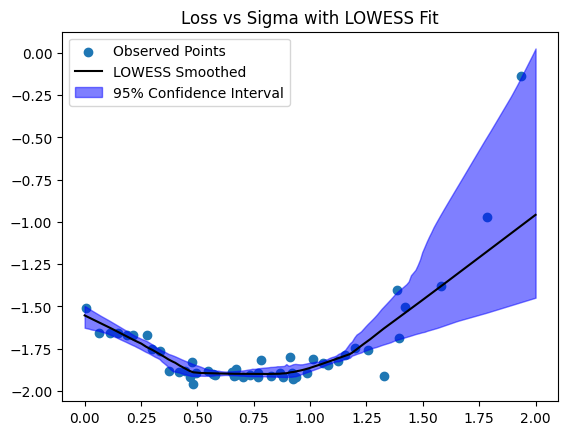

In [11]:
import wandb
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from guided_molecule_gen.optimizer import MoleculeGenerationOptimizer
from datetime import datetime


def lowess_with_confidence_bounds(x, y, eval_x, N=200, conf_interval=0.95, lowess_kw=None):
    """
    Perform Lowess regression and determine a confidence interval by bootstrap resampling.
    """
    # Lowess smoothing
    smoothed = sm.nonparametric.lowess(exog=x, endog=y, xvals=eval_x, **lowess_kw)

    # Bootstrap resampling for confidence intervals
    smoothed_values = np.empty((N, len(eval_x)))
    for i in range(N):
        sample = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x[sample]
        sampled_y = y[sample]
        smoothed_values[i, :] = sm.nonparametric.lowess(exog=sampled_x, endog=sampled_y, xvals=eval_x, **lowess_kw)
        

    # Confidence intervals
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(N * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top


# Initialize a W&B run
with wandb.init(name=f"HPO_visualization_{datetime.now().strftime('%Y%m%d_%H%M%S')}") as run:
    # Generate data, fit and plot
    completed_trials = [trial for trial in study.trials if trial.state == optuna.trial.TrialState.COMPLETE]
    trials_data = [{"sigma": trial.params["sigma"], "loss": trial.value, "trial_id": tid} for tid,trial in enumerate(completed_trials)]
    data = pd.DataFrame(trials_data)
    data = pd.DataFrame(trials_data)
    eval_x = np.linspace(0, 2, 200)
    smoothed, bottom, top = lowess_with_confidence_bounds(data.sigma, data.loss, eval_x, lowess_kw={"frac": 0.33})

    # Create plot

    fig, ax = plt.subplots()
    ax.scatter(data["sigma"], data["loss"], label="Observed Points")
    ax.plot(eval_x, smoothed, 'k', label="LOWESS Smoothed")
    ax.fill_between(eval_x, bottom, top, color='blue', alpha=0.5, label="95% Confidence Interval")
    ax.legend()
    ax.set_title("Loss vs Sigma with LOWESS Fit")
    
    # Log the plot to W&B
    run.log({"LOWESS Plot": wandb.Image(fig)})

    # Additional data to log
    smoothed_best_sigma = eval_x[np.argmin(smoothed)]  # Use the smoothed minimum
    run.log({"best_params": study.best_params, "smoothed_best_sigma": smoothed_best_sigma})
    smooth_best = {"sigma": smoothed_best_sigma}
    print("smooth_best:", smooth_best, "simple_best_param:",study.best_params)

## CMA-ES最適化
### 発見されたパラメータを用いて、より大規模なCMA-ES最適化を実行する
HPOで見つかったシグマの値が効果的であることが確認できたため、分子集団のサイズとステップ数を増やし、最後により大規模な最適化を実行します。

### 結果の探索
最適化のパフォーマンスを評価するために、生成された無効なサンプルの数を定量化することができます。「無効」とは、化学的に有効な分子を表さないSMILES文字列を指します。
実行後、ターゲット（QEDおよびタニモト類似度）の成分が各イテレーションでどのように変化したかを示すグラフを作成します。ターゲットの定義により、タニモト類似度が0.4以上の値が最適とされるため、その値の周囲にノイズが発生することが予想されます。同様に、QEDにおいても0.9以上の値が最適とされるため、その閾値を超える分子がある場合にはその値の周囲にノイズが発生することが予想されます。
WandBで結果を確認しましょう。

### 最適化のパフォーマンスはどれほど良かったのか？
最適化のパフォーマンスを評価するために、生成された無効なサンプルの数を定量化することができます。「無効」とは、化学的に有効な分子を表さないSMILES文字列を指します。

-> wandb内の`num_of_bad_samples`を確認しましょう

最終的に、ベースライン値に対するQEDの改善度と、望ましいタニモト類似度の閾値0.4以上を維持した最適化された分子の割合を定量化することができます。

-> wandb内の`mean_qed_improvement`、`tanimoto_above_04`を確認しましょう。

(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 512 (seed=1023655, Wed May 29 03:33:28 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 512 (seed=1005616, Wed May 29 03:33:28 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 512 (seed=1050686, Wed May 29 03:33:28 2024)


  0%|                                                                                             | 0/30 [00:00<?, ?it/s]

[NeMo I 2024-05-29 03:33:28 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


  3%|██▊                                                                                  | 1/30 [00:04<02:14,  4.64s/it]

[NeMo I 2024-05-29 03:33:32 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


  7%|█████▋                                                                               | 2/30 [00:09<02:08,  4.60s/it]

[NeMo I 2024-05-29 03:33:37 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 10%|████████▌                                                                            | 3/30 [00:14<02:06,  4.69s/it]

[NeMo I 2024-05-29 03:33:42 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 13%|███████████▎                                                                         | 4/30 [00:18<02:01,  4.66s/it]

[NeMo I 2024-05-29 03:33:47 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 17%|██████████████▏                                                                      | 5/30 [00:23<01:57,  4.70s/it]

[NeMo I 2024-05-29 03:33:51 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 20%|█████████████████                                                                    | 6/30 [00:27<01:51,  4.66s/it]

[NeMo I 2024-05-29 03:33:56 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 23%|███████████████████▊                                                                 | 7/30 [00:32<01:47,  4.69s/it]

[NeMo I 2024-05-29 03:34:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 27%|██████████████████████▋                                                              | 8/30 [00:37<01:42,  4.65s/it]

[NeMo I 2024-05-29 03:34:05 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 30%|█████████████████████████▌                                                           | 9/30 [00:42<01:38,  4.67s/it]

[NeMo I 2024-05-29 03:34:10 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 33%|████████████████████████████                                                        | 10/30 [00:46<01:32,  4.64s/it]

[NeMo I 2024-05-29 03:34:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 37%|██████████████████████████████▊                                                     | 11/30 [00:51<01:28,  4.68s/it]

[NeMo I 2024-05-29 03:34:19 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 40%|█████████████████████████████████▌                                                  | 12/30 [00:55<01:23,  4.65s/it]

[NeMo I 2024-05-29 03:34:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 43%|████████████████████████████████████▍                                               | 13/30 [01:00<01:19,  4.68s/it]

[NeMo I 2024-05-29 03:34:28 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 47%|███████████████████████████████████████▏                                            | 14/30 [01:05<01:14,  4.65s/it]

[NeMo I 2024-05-29 03:34:33 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 50%|██████████████████████████████████████████                                          | 15/30 [01:10<01:10,  4.71s/it]

[NeMo I 2024-05-29 03:34:38 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 53%|████████████████████████████████████████████▊                                       | 16/30 [01:14<01:05,  4.66s/it]

[NeMo I 2024-05-29 03:34:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 57%|███████████████████████████████████████████████▌                                    | 17/30 [01:19<01:00,  4.69s/it]

[NeMo I 2024-05-29 03:34:47 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 60%|██████████████████████████████████████████████████▍                                 | 18/30 [01:23<00:55,  4.65s/it]

[NeMo I 2024-05-29 03:34:52 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 63%|█████████████████████████████████████████████████████▏                              | 19/30 [01:28<00:51,  4.67s/it]

[NeMo I 2024-05-29 03:34:56 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 67%|████████████████████████████████████████████████████████                            | 20/30 [01:33<00:46,  4.65s/it]

[NeMo I 2024-05-29 03:35:01 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 70%|██████████████████████████████████████████████████████████▊                         | 21/30 [01:38<00:42,  4.68s/it]

[NeMo I 2024-05-29 03:35:06 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 73%|█████████████████████████████████████████████████████████████▌                      | 22/30 [01:42<00:37,  4.64s/it]

[NeMo I 2024-05-29 03:35:11 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 77%|████████████████████████████████████████████████████████████████▍                   | 23/30 [01:47<00:32,  4.67s/it]

[NeMo I 2024-05-29 03:35:15 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 80%|███████████████████████████████████████████████████████████████████▏                | 24/30 [01:51<00:27,  4.63s/it]

[NeMo I 2024-05-29 03:35:20 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 83%|██████████████████████████████████████████████████████████████████████              | 25/30 [01:56<00:23,  4.68s/it]

[NeMo I 2024-05-29 03:35:24 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 87%|████████████████████████████████████████████████████████████████████████▊           | 26/30 [02:01<00:18,  4.64s/it]

[NeMo I 2024-05-29 03:35:29 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 90%|███████████████████████████████████████████████████████████████████████████▌        | 27/30 [02:05<00:14,  4.68s/it]

[NeMo I 2024-05-29 03:35:34 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 93%|██████████████████████████████████████████████████████████████████████████████▍     | 28/30 [02:10<00:09,  4.64s/it]

[NeMo I 2024-05-29 03:35:39 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


 97%|█████████████████████████████████████████████████████████████████████████████████▏  | 29/30 [02:15<00:04,  4.68s/it]

[NeMo I 2024-05-29 03:35:43 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


100%|████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:19<00:00,  4.66s/it]


num_of_bad_samples: 0.0030107526881720434 mean_qed_improvement: 0.4224499582828221 tanimoto_above_04: 0.6666666666666666


mean_qed_improvement,▁
num_of_bad_samples,▁
tanimoto_above_04,▁
mean_qed_improvement,0.42245
num_of_bad_samples,0.00301
tanimoto_above_04,0.66667


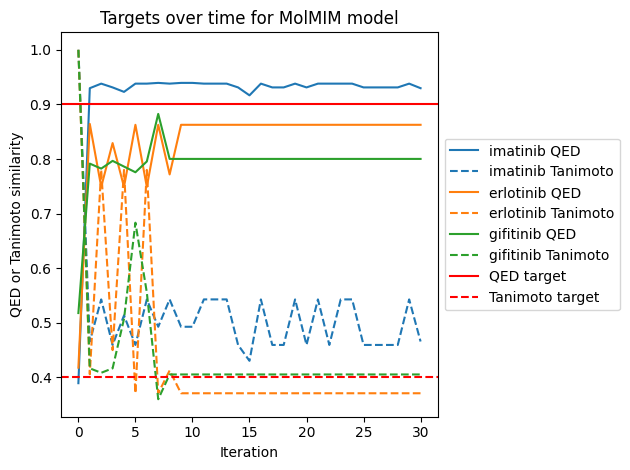

In [12]:
import wandb
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from guided_molecule_gen.optimizer import MoleculeGenerationOptimizer
from tqdm import trange
from datetime import datetime

# Initialize a W&B run
with wandb.init(name=f"CMS_EA_Optimization_{datetime.now().strftime('%Y%m%d_%H%M%S')}") as run:
    # Assuming model_wrapped and scoring_function are defined elsewhere
    optimizer = MoleculeGenerationOptimizer(
        model_wrapped,
        scoring_function,
        canonicalized_smiles,
        popsize=50,  # larger values will be slower but more thorough
        optimizer_args=smooth_best,  # Vals from HPO
    )
    
    columns = ["iteration", "idx","molecure", "smiles", "structure", "qud_score", "tanimoto_score"]
    optimization_results = wandb.Table(columns=columns)

    # Starting state for idx 0
    qed_scores = [qed(canonicalized_smiles)]
    tanimoto_scores = [[tanimoto_similarity([canonicalized_smiles[idx]], canonicalized_smiles[idx])[0] for idx in range(len(canonicalized_smiles))]]
    best_molecules = [canonicalized_smiles]
    fraction_bad_samples = [[0] * len(canonicalized_smiles)]

    for i in trange(30):
        optimizer.step()
        final_smiles = optimizer.generated_smis
        # Population of molecules is returned, but we only want the best one.
        _qed_scores = []
        _tanimoto_scores = []
        _best_molecules = []
        _fraction_bad = []
        ca_id = 0
        for smis_population, reference_smis in zip(final_smiles, canonicalized_smiles):
            idx = np.argmin(scoring_function(smis_population, reference_smis))
            _fraction_bad.append(np.mean(qed(smis_population) == 0))
            _best_molecules.append(smis_population[idx])
            _qed_scores.append(qed([smis_population[idx]])[0])
            _tanimoto_scores.append(tanimoto_similarity([smis_population[idx]], reference_smis)[0])
            
            
            mol = Chem.MolFromSmiles(smis_population[idx])
            wandb_molecule = wandb.Molecule.from_rdkit(mol)
            
            optimization_results.add_data(i, idx,["imatinib", "erlotinib", "gifitinib"][ca_id], smis_population[idx], wandb_molecule, qed([smis_population[idx]])[0], tanimoto_similarity([smis_population[idx]], reference_smis)[0])
            ca_id=+1

        qed_scores.append(_qed_scores)
        tanimoto_scores.append(_tanimoto_scores)
        best_molecules.append(_best_molecules)
        fraction_bad_samples.append(_fraction_bad)

    run.log({"optimization_results":optimization_results})

    # Plotting results
    fig, ax = plt.subplots()
    for i, molecule in enumerate(["imatinib", "erlotinib", "gifitinib"]):
        line, = plt.plot(np.arange(len(qed_scores)), [q[i] for q in qed_scores], label=f"{molecule} QED")
        color = line.get_color()
        plt.plot(np.arange(len(tanimoto_scores)), [t[i] for t in tanimoto_scores], label=f"{molecule} Tanimoto", linestyle="--", color=color)
    plt.axhline(y=0.9, color='r', linestyle='-', label="QED target")
    plt.axhline(y=0.4, color='r', linestyle='--', label="Tanimoto target")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Iteration")
    plt.ylabel("QED or Tanimoto similarity")
    plt.title("Targets over time for MolMIM model")
    plt.tight_layout()

    # Log the plot to W&B
    run.log({"LOWESS Plot": wandb.Image(fig)})

    # Additional calculations and logs
    qed_improvements = []
    tanimoto_above_04 = []
    for i in range(len(starting_qed)):
        tanimoto_above_04.append(tanimoto_scores[-1][i] >= 0.4)
        qed_improvements.append(qed_scores[-1][i] - starting_qed[i])
    
    metrics = {
        "num_of_bad_samples": np.mean(fraction_bad_samples),
        "mean_qed_improvement": np.mean(qed_improvements),
        "tanimoto_above_04": np.mean(tanimoto_above_04),
    }
    
    run.log(metrics)
    
    # Print metrics
    print("num_of_bad_samples:", np.mean(fraction_bad_samples),"mean_qed_improvement:", metrics["mean_qed_improvement"], "tanimoto_above_04:", metrics["tanimoto_above_04"])
